In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from evidential import *
from util import *


In [85]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [86]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [87]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA GeForce GTX 1080 Ti


In [88]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = True
save_values = False

#Data constants
shapes = [2, 6]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
large_gridfile = f"grid_r_a1_2500_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
large_grid_data = pd.read_csv(f"../data/{large_gridfile}.csv")
grid_rmax = grid_data["x1"].max()
large_grid_rmax = large_grid_data["r"].max()

# Max accuracy on test set
max_acc = np.sum(train_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(train_data)
print("Max acc train data: ", max_acc)
max_acc = np.sum(test_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(test_data)
print("Max acc test data: ", max_acc)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

X_large_grid = torch.Tensor(np.dstack((large_grid_data[x1_key], large_grid_data[x2_key]))).to(torch.float32)[0]
Y_large_grid = torch.zeros(X_large_grid.shape)

Max acc train data:  0.7405497427147698
Max acc test data:  0.7385207198110306


In [89]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)
large_grid_dataset = torch.utils.data.TensorDataset(X_large_grid, Y_large_grid)

In [90]:
model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
#model = SequentialNet(L=5000, n_hidden=4, activation="relu", in_channels=2, out_channels=2).to(device)
model # Check that everything looks good

SequentialNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
  )
  (first_layer): Linear(in_features=2, out_features=200, bias=True)
  (last_layer): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

Text(0.5, 0.98, 'Number of training datapoints: 0')

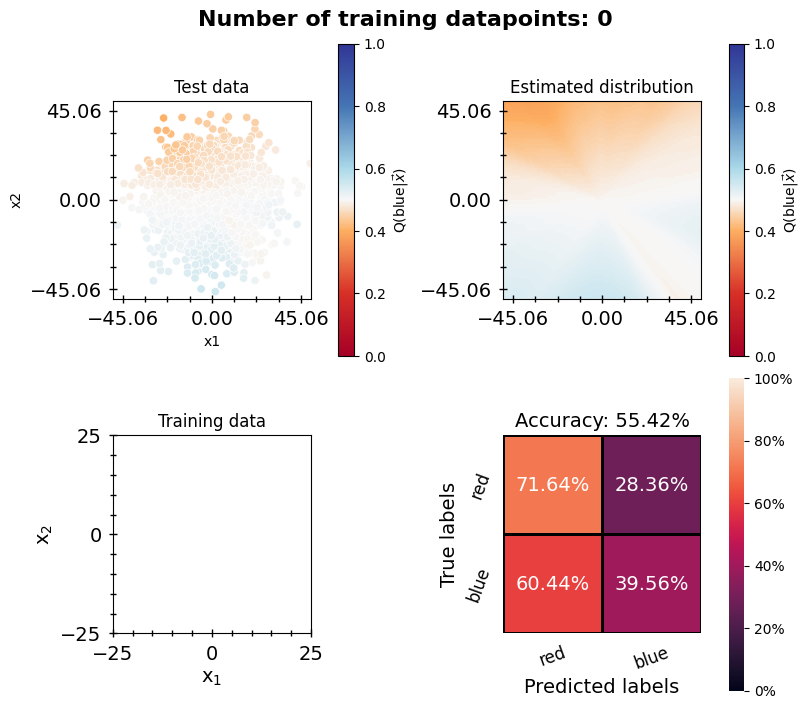

In [91]:
probs, uncertainties, beliefs = predict_evidential_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Est_prob_blue"] = probs[:,1] #Get softmax score for blue

probs, uncertainties, beliefs = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
grid_data["Prediction"] = preds
grid_data["Est_prob_blue"] = probs[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Est_prob_blue", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: 0", size=16, fontweight="bold")

 49%|████▉     | 49/100 [00:11<00:12,  4.13it/s]

Stopping training early at epoch 49


<Axes: xlabel='Iteration'>

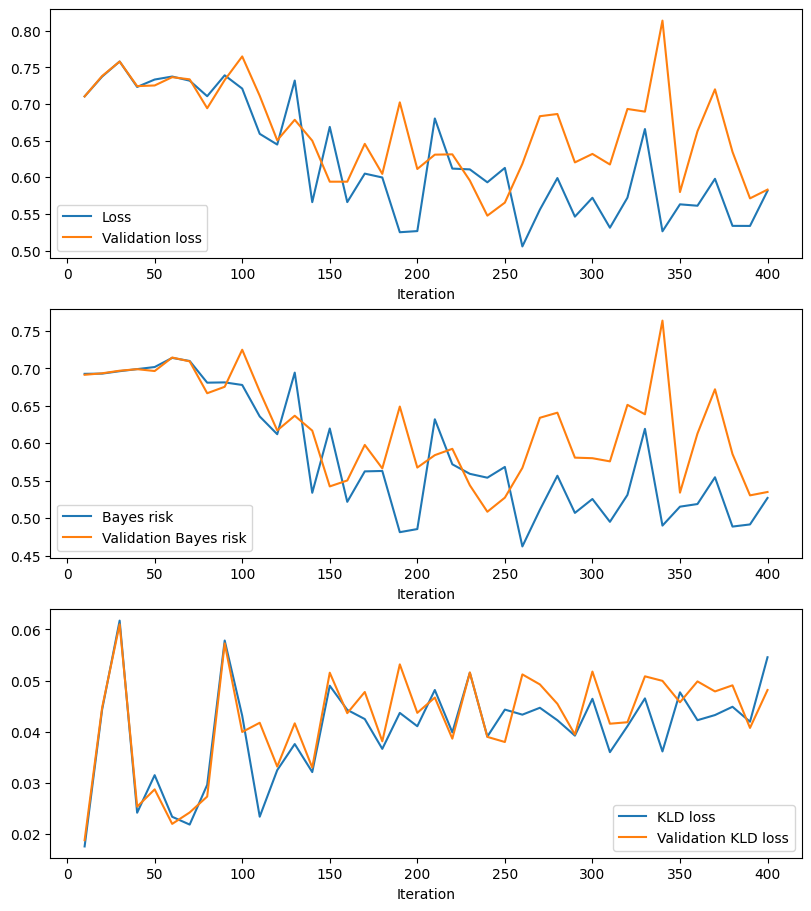

In [92]:
n_train = 1000
patience = 20
epochs = 100 # Affects annealing. Keep this constant and regulate with annealing_coeff
lr = 0.001 # Too high or too low gives no learning
batchsize = 128
annealing_coef = 0.2

model = SequentialNet(L=2000, n_hidden=8, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

train_dataset_small = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
training_results = train_evidential_classifier(model, train_dataset_small, 
                         val_dataset, batchsize=batchsize, epochs = epochs, 
                         device = device, optimizer = optimizer, annealing_coef=annealing_coef, early_stopping=patience)
probs, uncertainties, beliefs = predict_evidential_classifier(model, test_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 3*3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
training_results.plot("Iteration", ["Bayes risk", "Validation Bayes risk"], ax=axs[1])
training_results.plot("Iteration", ["KLD loss", "Validation KLD loss"], ax=axs[2])

Text(0.5, 0.98, 'Number of training datapoints: 1000')

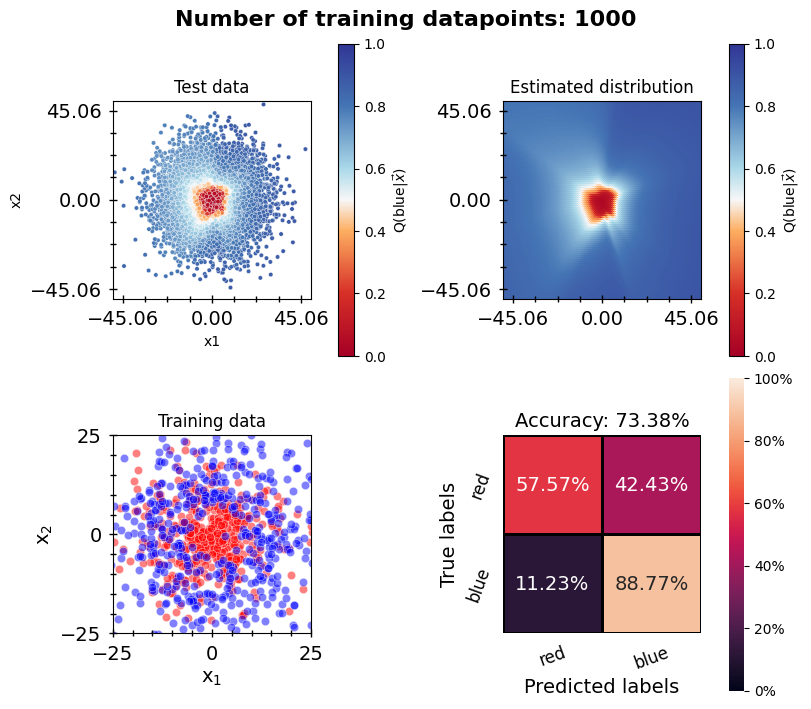

In [93]:
probs, uncertainties, beliefs = predict_evidential_classifier(model, test_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
test_data["Prediction"] = preds
#Get softmax score for blue
test_data["Est_prob_blue"] = probs[:,1]
test_data["Uncertainty"] = uncertainties[:,1]
test_data["0.5_uncertainty"] = uncertainties[:,1]/2
test_data["Beliefs"] = beliefs[:,1]

probs, uncertainties, beliefs = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
grid_data["Prediction"] = preds
#Get softmax score for blue
grid_data["Est_prob_blue"] = probs[:,1]
grid_data["Uncertainty"] = uncertainties[:,1]
grid_data["0.5_uncertainty"] = uncertainties[:,1]/2
grid_data["Beliefs"] = beliefs[:,1]

probs, uncertainties, beliefs = predict_evidential_classifier(model, large_grid_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
large_grid_data["Prediction"] = preds
#Get softmax score for blue
large_grid_data["Est_prob_blue"] = probs[:,1]
large_grid_data["Uncertainty"] = uncertainties[:,1]
large_grid_data["0.5_uncertainty"] = uncertainties[:,1]/2
large_grid_data["Beliefs"] = beliefs[:,1]

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(test_data, "Est_prob_blue", axs[0][0], "Test data", error_key="0.5_uncertainty", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(test_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")


cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


In [94]:
val_data.copy()["p_c0"].loc[2] = 0.5

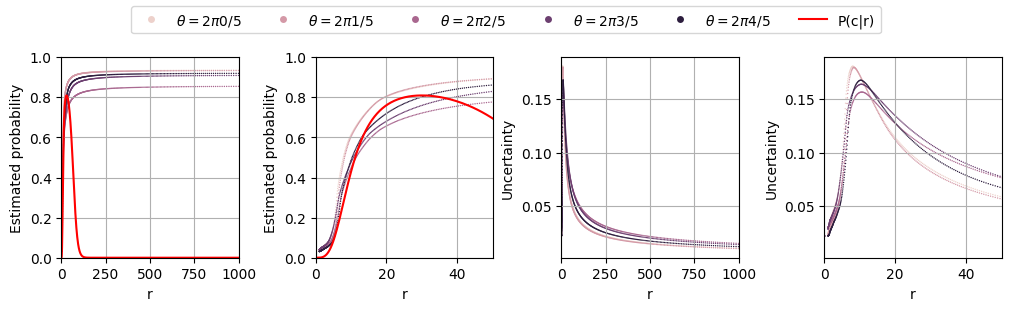

In [95]:
def plot_large_grid(df):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y="Est_prob_blue", hue="n_a1", ax=axs[0], s=1, alpha=1, linewidth=0, legend="full")
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[0], label="P(c|r)", color="red")
    
    axs[0].set_ylabel("Estimated probability", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y="Est_prob_blue", hue="n_a1", ax=axs[1], s=1, alpha=1, linewidth=0, legend=False)
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1], legend=False, color="red")
    axs[1].set_ylabel("Estimated probability", size=10)
    axs[1].set_xlim(0, grid_rmax)
    axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y="Uncertainty", hue="n_a1", ax=axs[2], s=1, alpha=1, linewidth=0, legend=False)
    axs[2].set_ylabel("Uncertainty", size=10)
    #axs[2].set_ylim(0, 1)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y="Uncertainty", hue="n_a1", ax=axs[3], s=1, alpha=1, linewidth=0, legend=False)
    axs[3].set_ylabel("Uncertainty", size=10)
    axs[3].set_xlim(0, grid_rmax)
    #axs[3].set_ylim(0, 1)

    for ax in axs:
        ax.grid(True)

    handles, labels = axs[0].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/{len_labels}"
    axs[0].get_legend().remove()
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)

plot_large_grid(large_grid_data)

In [96]:
large_r_df = large_grid_data.copy()[large_grid_data["r"] > 700]
mean_pc1 = large_r_df["Est_prob_blue"].mean()
print(mean_pc1)

0.90964836


<Axes: xlabel='r', ylabel='Count'>

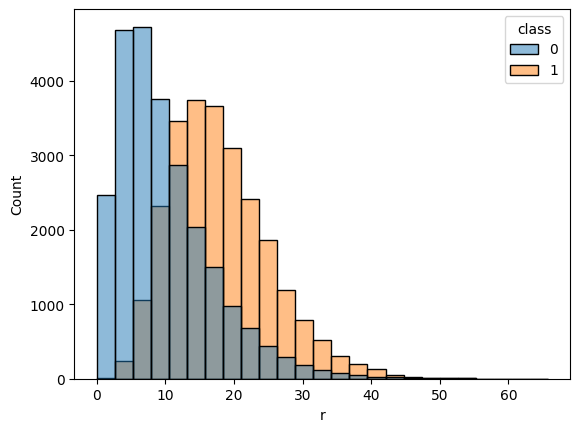

In [97]:
sn.histplot(train_data, x="r", hue="class", bins=25)
#plt.xlim(25, 30)
#plt.ylim(0, 30)

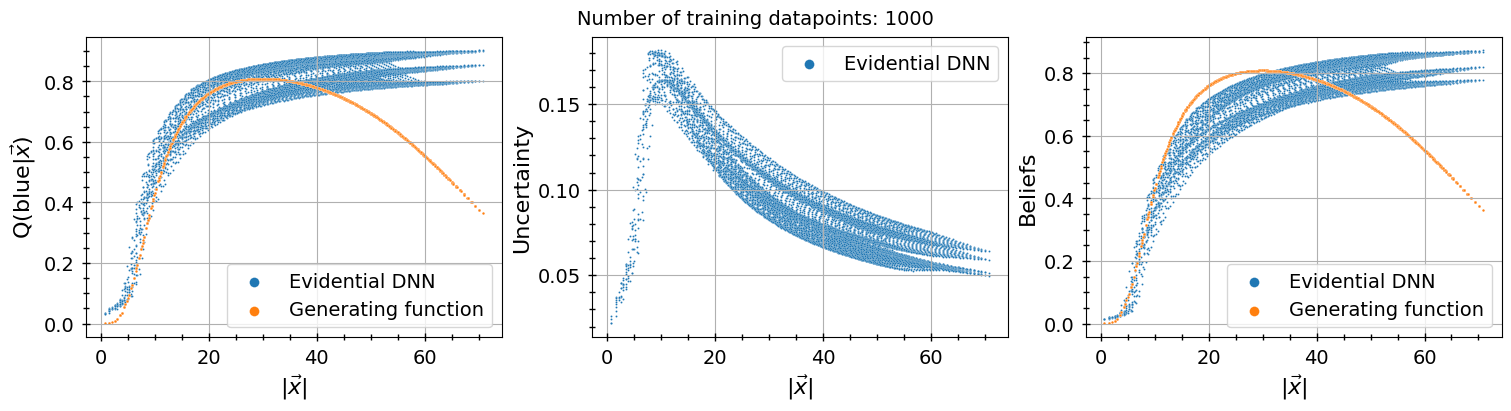

In [98]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize= (5*3, 4), layout="constrained")

sn.scatterplot(grid_data, x="r", y="Est_prob_blue", s=2, ax = axs[0], label ="Evidential DNN")
sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function")
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(grid_data, x="r", y="Uncertainty", s=2, ax = axs[1], label ="Evidential DNN")
axs[1].set_ylabel(r"Uncertainty", fontsize=16)

sn.scatterplot(grid_data, x="r", y="Beliefs", s=2, ax = axs[2], label ="Evidential DNN")
sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[2], label="Generating function")
axs[2].set_ylabel(r"Beliefs", fontsize=16)

fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)
for ax in axs:
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.legend(markerscale=5, fontsize=14)

Text(0.5, 0.98, 'Number of training datapoints: 1000')

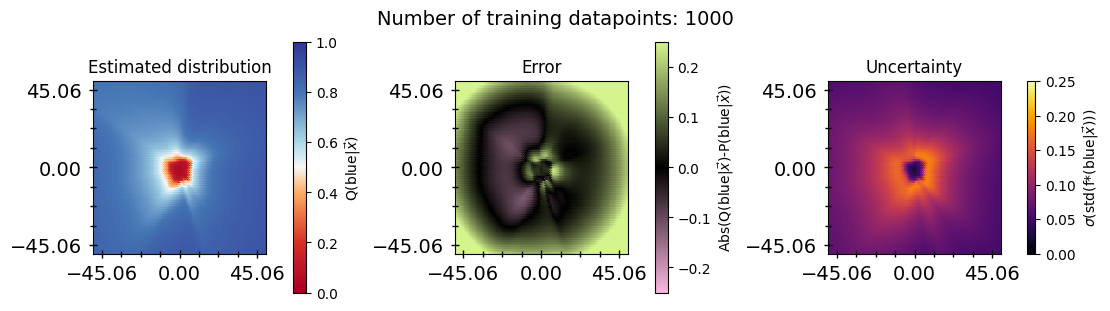

In [99]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

axs[0] = plot_results(grid_data, "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_diff(grid_data, grid_data, "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=0.25, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

axs[2] = plot_std(grid_data, "Uncertainty", axs[2], "Uncertainty", grid=True, max_val=0.25, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=0.25, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)


Text(0.5, 0.98, 'Number of training datapoints: 1000')

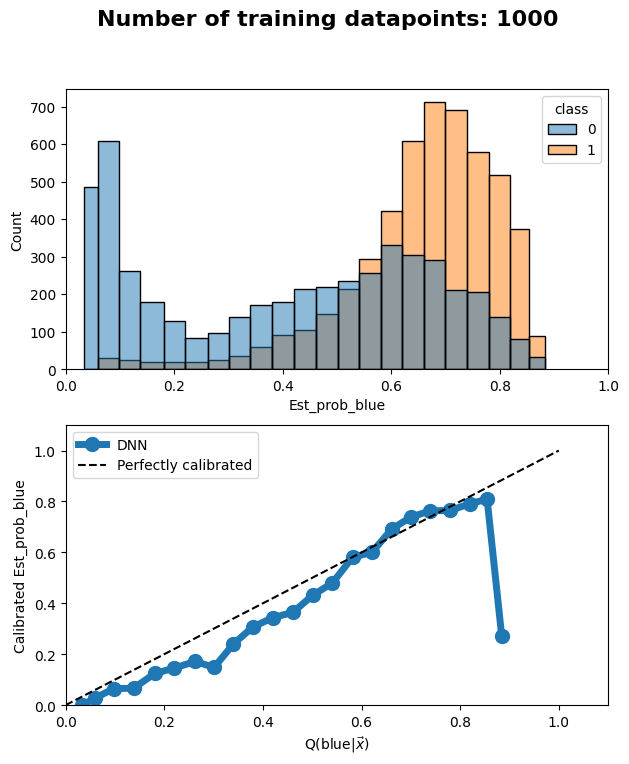

In [100]:
prob_cal, prob_pred = calibration_curve(test_data["class"], test_data["Est_prob_blue"], n_bins=25, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
sn.histplot(test_data, x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
ax[1].set_ylabel("Calibrated Est_prob_blue")
ax[1].legend()
fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")

In [ ]:
# Vary hyperparameters
def create_df(ntrain, hyperparam_dict):
    # Total number of combinations of hyperparams
    n_var_hyperparams = 1
    for key in hyperparams.keys():
        n_var_hyperparams = n_var_hyperparams*len(hyperparam_dict[key])

    # Create dataframe
    df = pd.DataFrame(columns=hyperparam_dict.keys())
    df["ntrain"] = np.array([ntrain]*n_var_hyperparams).flatten()
    # With all permutations
    iter_perms_down = n_var_hyperparams
    iter_perms_up = 1
    for key in hyperparam_dict.keys():
        values = hyperparam_dict[key]
        iter_perms_down = int(iter_perms_down/len(values))
        df[key] = np.array([[x]*iter_perms_down for x in values]*iter_perms_up).flatten()
        iter_perms_up = int(iter_perms_up*len(values))

    # Nodes
    df["nodes"] = np.zeros(len(df))
    nodes = [20, 200, 2000]
    for i in range(len(hyperparam_dict["layers"])):
        n_layers = hyperparam_dict["layers"][i]
        df_copy = df.copy()
        mask = df_copy["layers"] == n_layers
        df.loc[mask, "nodes"] = nodes[i]
    return df

n_runs = 1
SAVE_PREDS = True
hyperparams = {
    "lr" : [0.1, 0.01, 0.001],
    "weight_decay" : [0.1, 0.01, 0.001],
    "annealing_coef" : [0.05, 0.1, 0.2],
    "layers" : [1, 3, 8]
}
n_train = n_data[2]
batchsize = bs_list[2]
patience = 20 # For early stopping
epochs = 100 #Affects annealing constant, don't change

print("Starting hyperparameter search")
train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
# Run more times for statistics
for j in range(n_runs):
    df_run = create_df(n_train, hyperparams)
    metric_keys = ["ACC", "LogLoss", "Mean KL-div", "ECE", "WD", "Mean UQ", 
                    "Std UQ", "Min UQ", "Max UQ",
                    "Mean Pc1 OOD", "Std Pc1 OOD", "Max Pc1 OOD", "Min Pc1 OOD",
                    "Mean UQ OOD", "Std UQ OOD", "Max UQ OOD", "Min UQ OOD"]
    for key in metric_keys:
        df_run[key] = None
    print(f"Testing {len(df_run)} hyperparameter combinations in run nr {j + 1} out of {n_runs}")
    # Run once for each hyperparameter combination
    for i in range(len(df_run)):
        val_df = pd.read_csv(f"../data/{valfile}.csv")
        large_grid_df = pd.read_csv(f"../data/{large_gridfile}.csv")
        
        # Get parameters
        lr = df_run["lr"].values[i]
        weight_decay = df_run["weight_decay"].values[i]
        n_layers = int(df_run["layers"].values[i])
        n_nodes = int(df_run["nodes"].values[i])
        annealing_coef = df_run["annealing_coef"].values[i]
        
        # Initialize model and optimizer
        model = SequentialNet(L=n_nodes, n_hidden=n_layers, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train model
        training_results = train_evidential_classifier(model, train_dataset, 
                                val_dataset, batchsize=batchsize, epochs = epochs, 
                                device = device, optimizer = optimizer, 
                                annealing_coef=annealing_coef, early_stopping=patience)
        # Evaluate on validation set
        est_probs_val, uncertainties_val, beliefs_val = predict_evidential_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(est_probs_val, dim=-1).flatten()
        val_df["Prediction"] = preds_val
        val_df["Est_prob_c1"] = est_probs_val[:,1] #Get probability score for blue
        val_df["Std_prob_c1"] = uncertainties_val[:,1]
        
        len_nan = len(val_df[val_df.isnull().any(axis=1)])
        if (len_nan < len(val_df)):
            if len_nan > 0:
                print(f"Dropping {len_nan} rows of NaNs from validation file")
                val_df = val_df.dropna()
            # Make them tensors (might be redundant)
            est_probs = torch.Tensor(val_df["Est_prob_c1"])
            pred_class = torch.Tensor(val_df["Prediction"])
            target = torch.Tensor(val_df["class"])
            truth_probs = torch.Tensor(val_df["p_c1_given_r"])

            # Calculate metrics
            ll = log_loss(target, est_probs)
            df_run.loc[i, "ACC"] = accuracy_score(target, pred_class)
            df_run.loc[i, "LogLoss"] = ll
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(est_probs, target).item()
            df_run.loc[i, "ECE"] = ece
            df_run.loc[i, "WD"] = wasserstein_distance(truth_probs, est_probs)
            df_run.loc[i, "Mean KL-div"] = kl_div(truth_probs, est_probs).mean().numpy()
            df_run.loc[i, "Mean UQ"] = val_df["Std_prob_c1"].mean()
            df_run.loc[i, "Std UQ"] = val_df["Std_prob_c1"].std()
            df_run.loc[i, "Max UQ"] = val_df["Std_prob_c1"].max()
            df_run.loc[i, "Min UQ"] = val_df["Std_prob_c1"].min()

            # Evaluate on large grid
            est_probs_large_grid, uncertainties_large_grid, beliefs_large_grid = predict_evidential_classifier(model, 
                large_grid_dataset, 2, 100, device)
            preds_large_grid = torch.argmax(est_probs_large_grid, dim=-1).flatten()
            large_grid_df["Prediction"] = preds_large_grid
            large_grid_df["Est_prob_c1"] = est_probs_large_grid[:,1] #Get probability score for blue
            large_grid_df["Std_prob_c1"] = uncertainties_large_grid[:,1]

            large_r_df = large_grid_df.copy()[large_grid_df["r"] > 700]

            df_run.loc[i, "Mean Pc1 OOD"] = large_r_df["Est_prob_c1"].mean()
            df_run.loc[i, "Std Pc1 OOD"] = large_r_df["Est_prob_c1"].std()
            df_run.loc[i, "Max Pc1 OOD"] = large_r_df["Est_prob_c1"].max()
            df_run.loc[i, "Min Pc1 OOD"] = large_r_df["Est_prob_c1"].min()

            df_run.loc[i, "Mean UQ OOD"] = large_r_df["Std_prob_c1"].mean()
            df_run.loc[i, "Std UQ OOD"] = large_r_df["Std_prob_c1"].std()
            df_run.loc[i, "Max UQ OOD"] = large_r_df["Std_prob_c1"].max()
            df_run.loc[i, "Min UQ OOD"] = large_r_df["Std_prob_c1"].min()

            print(df_run)
        else:
            print("WTF is going on here?? Skipping these")
            print(df_run.loc[i])
            print(val_df["Est_prob_c1"])